In [1]:
import numpy as np
from numpy import nan
import pandas as pd
import json
from csv import writer
PATH_ROOT = "D:/Desktop/Northeastern_University/Research/Proteomics/ProteinProteinAssociation/Development"

In [2]:
# original vector values are both nonzero
def find_common_observations(vector1,vector2):
  vector1_bool = np.where(vector1 != 0, 1, 0)
  vector2_bool = np.where(vector2 != 0, 1, 0)
  take_indices = np.logical_and(vector1_bool,vector2_bool)
  take_indices = take_indices.nonzero()[0]
  x1 = np.take(vector1,take_indices)
  x2 = np.take(vector2,take_indices)
  return x1,x2

# Appends list of tuples to csv
def append_to_csv(file_name,column_names,cor_tuples):
  with open(file_name, 'a+', newline='') as write_obj:
    csv_writer = writer(write_obj)
    if column_names is not None:
      csv_writer.writerow(column_names)
    for cor_tuple in cor_tuples:
      csv_writer.writerow(cor_tuple)

def write_json_to(json_dict,path):
  json_to_write = json.dumps(json_dict)
  write_file = open(path,"w")
  write_file.write(json_to_write)
  write_file.close()

def read_json_from(path):
  with open(path, "r") as read_file:
    init_dict = json.load(read_file)
    if isinstance(init_dict,str):
        return eval(init_dict)
    return init_dict

def progress_report(cur_idx,total,start_time):
    percent_done = (cur_idx+1) / total
    print(f"Percent done: {percent_done}")
    time_since_start = time.time() - start_time
    print(f"Time elasped: {time_since_start}")
    print(f"Estimate finishing in: {time_since_start / (percent_done) - time_since_start}") 


In [3]:
proteomeHD_df_path = f"{PATH_ROOT}/data_sources/ProteomeHD/ProteomeHD_v1_1.csv"
proteomeHD_df = pd.read_csv(proteomeHD_df_path)
proteomeHD_simplified_ids = proteomeHD_df["Simplified_protein_ID"].to_numpy()
proteomeHD_feature_matrix = proteomeHD_df.iloc[:,4:].fillna(0).to_numpy()

major_simplified_idx_lookup_path = f"{PATH_ROOT}/data_sources/ProteomeHD/major_simplified_to_idx_lookup.json"
major_simplified_idx_lookup = read_json_from(major_simplified_idx_lookup_path)

coexpression_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_coexpression_relation_lookup.json"
cooccurence_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_cooccurence_relation_lookup.json"
experiments_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_experiments_relation_lookup.json"
fusion_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_fusion_relation_lookup.json"
homology_lookup_path = f"{PATH_ROOT}/data_sources/StringDB/human/medium_confidence_homology_relation_lookup.json"
cocomplex_lookup_path = f"{PATH_ROOT}/data_sources/Corum/all_corum_complex_pairs_size_only.json"

coexpression_lookup = read_json_from(coexpression_lookup_path)
cooccurence_lookup = read_json_from(cooccurence_lookup_path)
experiments_lookup = read_json_from(experiments_lookup_path)
fusion_lookup = read_json_from(fusion_lookup_path)
homology_lookup = read_json_from(homology_lookup_path)
cocomplex_lookup = read_json_from(cocomplex_lookup_path)

lookup_list = [coexpression_lookup,cooccurence_lookup,experiments_lookup,fusion_lookup,homology_lookup,cocomplex_lookup]

In [4]:
# kNN
def get_top_k_nearest_neighbors(vector,k,candidates,dist_function):
    k += 1
    dist_to_all = np.array(list(map(lambda x: dist_function(vector,x),candidates)))
    neighbor_indices = np.argpartition(dist_to_all, k)[0:k]
    neighbor_indices = neighbor_indices[np.argsort(dist_to_all[neighbor_indices])]
    neighbor_indices = neighbor_indices[1:]
    top_k_neighbors_dist = dist_to_all[neighbor_indices]
    return neighbor_indices,top_k_neighbors_dist

# returns report json containing relations between two proteins
def eval_relation(protein1,protein2):
    report_json = {}
    for lookup in lookup_list:
        lookup_type = lookup['relation_type']
        relation_score = float('NaN')
        try:
            relation_score = lookup[protein1][protein2]
        except KeyError:
            pass
        report_json[lookup_type] = relation_score
    return report_json

def protein_query(protein,k,dist_function,feature_matrix=proteomeHD_feature_matrix,lookup=major_simplified_idx_lookup):
    query_report = {}
    query_report['protein_queried'] = protein
    query_report['k'] = k
    query_report['dist_function'] = dist_function.__name__
    query_report['neighbors'] = {}
    protein_idx = lookup[protein]
    protein_vec = feature_matrix[protein_idx]
    neighbor_indices,neighbor_dists = get_top_k_nearest_neighbors(protein_vec,k,feature_matrix,dist_function)
    protein_neighbors = proteomeHD_simplified_ids[neighbor_indices]
    for idx,entry in enumerate(protein_neighbors):
        query_report['neighbors'][entry] = eval_relation(protein,entry)
        query_report['neighbors'][entry]['distance'] = neighbor_dists[idx]
    return query_report

# Define Distance Functions

In [5]:
def find_common_observations(vector1,vector2):
  vector1_bool = np.where(vector1 != 0, 1, 0)
  vector2_bool = np.where(vector2 != 0, 1, 0)
  take_indices = np.logical_and(vector1_bool,vector2_bool)
  take_indices = take_indices.nonzero()[0]
  x1 = np.take(vector1,take_indices)
  x2 = np.take(vector2,take_indices)
  return x1,x2

def pearson_dist(vec1,vec2):
    return 1- np.corrcoef(vec1,vec2)[0,1]

def pearson_dist_wrapper(p1_vec,p2_vec):
    vec1,vec2 = find_common_observations(p1_vec,p2_vec)
    if len(vec1) < 2: return float('Nan')
    return pearson_dist(vec1,vec2)

def normalized_manhattan_dist(vec1,vec2):
    diff = np.where(vec1>=vec2, vec1,vec2) - np.where(vec1<vec2, vec1,vec2)
    normalizing_factor = np.sum(np.maximum(np.maximum(vec1,vec2),diff))
    if normalizing_factor == 0: return float('NaN')
    return np.sum(diff) / normalizing_factor

def normalized_manhattan_dist_wrapper(p1_vec,p2_vec):
    vec1,vec2 = find_common_observations(p1_vec,p2_vec)
    if len(vec1) == 0: return float('Nan')
    return normalized_manhattan_dist(vec1,vec2)

def euclidean_dist(vec1,vec2):
    return np.linalg.norm(vec1-vec2)

def euclidean_dist_wrapper(p1_vec,p2_vec):
    vec1,vec2 = find_common_observations(p1_vec,p2_vec)
    if len(vec1) == 0: return float('Nan')
    return euclidean_dist(vec1,vec2)

# Perform Queries

In [6]:
tSNE_path = f"{PATH_ROOT}/data_sources/ProteomeHD/tSNE.csv"
tSNE_df = pd.read_csv(tSNE_path)
tSNE_majority_protein_id = tSNE_df['ID'].to_numpy()
#tSNE_simplified_protein_id = list(map(lambda x: proteomeHD_df.loc[proteomeHD_df['Majority_protein_IDs'] == x]['Simplified_protein_ID'].values[0],tSNE_df['ID'].to_numpy()))
tSNE_embedding = tSNE_df[['V1','V2']].to_numpy()
tSNE_lookup = read_json_from( f"{PATH_ROOT}/data_sources/ProteomeHD/tSNE_lookup.json")

In [11]:
embedding_feature_matrix_path = f"{PATH_ROOT}/embeddings/umap/numpy_files/cosine/n_50_minDist_35_com_2.npy"
embedding_featuer_matrix = np.load(embedding_feature_matrix_path)

In [335]:
report_list = []
for idx,protein in enumerate(tSNE_majority_protein_id):
    report_list.append(protein_query(protein,5,euclidean_dist_wrapper,tSNE_embedding,tSNE_lookup))
    if idx % 500 == 1:
        print(idx)

1
501
1001
1501
2001
2501
3001
3501
4001
4501
5001


In [336]:
report_list


[{'protein_queried': 'A0AV96-2;A0AV96',
  'k': 5,
  'dist_function': 'euclidean_dist_wrapper',
  'neighbors': {'O95571': {'coexpression': nan,
    'cooccurence': nan,
    'experiments': nan,
    'fusion': nan,
    'homology': nan,
    'cocomplex': nan,
    'distance': 0.1076099009954584},
   'P51991': {'coexpression': nan,
    'cooccurence': nan,
    'experiments': nan,
    'fusion': nan,
    'homology': nan,
    'cocomplex': nan,
    'distance': 0.701156401298157},
   'P50747': {'coexpression': nan,
    'cooccurence': nan,
    'experiments': nan,
    'fusion': nan,
    'homology': nan,
    'cocomplex': nan,
    'distance': 1.0394727936255914},
   'P19404': {'coexpression': nan,
    'cooccurence': nan,
    'experiments': nan,
    'fusion': nan,
    'homology': nan,
    'cocomplex': nan,
    'distance': 1.2125444701007186},
   'P49585': {'coexpression': nan,
    'cooccurence': nan,
    'experiments': nan,
    'fusion': nan,
    'homology': nan,
    'cocomplex': nan,
    'distance': 1.34

In [337]:
summary = {}
for report in report_list:
    protein = report['protein_queried']
    for neighbor in report['neighbors']:
        for key in report['neighbors'][neighbor]:
            if key != 'distance':
                if report['neighbors'][neighbor][key] > 0:
                    if key not in summary:
                        summary[key] = 1
                    else:
                        summary[key] += 1

In [4]:
report_path_1 = f"{PATH_ROOT}/data_sources/StringDB/human/embedding_report/n_15_minDist_5_com_2_report.json"
report_path_2 = f"{PATH_ROOT}/data_sources/StringDB/human/embedding_report/n_50_minDist_35_com_2_report.json"
report_path_3 = f"{PATH_ROOT}/data_sources/StringDB/human/embedding_report/tSNE_report.json"

In [5]:
report_1 = read_json_from(report_path_1)
report_2 = read_json_from(report_path_2)
report_3 = read_json_from(report_path_3)


In [21]:
report_3['summary']

{'experiments': 19,
 'homology': 7,
 'cocomplex': 21,
 'coexpression': 6,
 'cooccurence': 1}

In [20]:
report_2['queries'][0]

{'protein_queried': 'A0AV96',
 'k': 5,
 'dist_function': 'euclidean_dist_wrapper',
 'neighbors': {'Q9Y2I9': {'coexpression': nan,
   'cooccurence': nan,
   'experiments': nan,
   'fusion': nan,
   'homology': nan,
   'cocomplex': nan,
   'distance': 0.04408227},
  'Q6ZTU2': {'coexpression': nan,
   'cooccurence': nan,
   'experiments': nan,
   'fusion': nan,
   'homology': nan,
   'cocomplex': nan,
   'distance': 0.052211214},
  'Q8IU60': {'coexpression': nan,
   'cooccurence': nan,
   'experiments': nan,
   'fusion': nan,
   'homology': nan,
   'cocomplex': nan,
   'distance': 0.05701978},
  'Q96CN9': {'coexpression': nan,
   'cooccurence': nan,
   'experiments': nan,
   'fusion': nan,
   'homology': nan,
   'cocomplex': nan,
   'distance': 0.09545438},
  'Q9UK45': {'coexpression': nan,
   'cooccurence': nan,
   'experiments': nan,
   'fusion': nan,
   'homology': nan,
   'cocomplex': nan,
   'distance': 0.098045856}}}

In [15]:
eval_relation('Q02790','P31948')

{'coexpression': 405,
 'cooccurence': nan,
 'experiments': nan,
 'fusion': nan,
 'homology': nan,
 'cocomplex': nan}

In [72]:
report_3['embedding_method'] = {}
report_3['embedding_method']['name'] = 'tsne'
report_3['embedding_method']['parameters'] = {}
report_3['embedding_method']['parameters']['is_distance'] = True
report_3['embedding_method']['parameters']['theta'] = 0
report_3['embedding_method']['parameters']['perplexity'] = 50
report_3['embedding_method']['parameters']['max_iter'] = 1500
report_3['embedding_method']

{'name': 'tsne',
 'parameters': {'is_distance': True,
  'theta': 0,
  'perplexity': 50,
  'max_iter': 1500}}

In [73]:
write_json_to(report_3,report_path_3)

In [81]:
def calc_relation_per_neighborhood(report,size):
    print(f"Embedding method: {report['embedding_method']['name']}")
    to_print = ''
    for key in report['embedding_method']['parameters']:
        to_print += f"{str(key)}:{str(report['embedding_method']['parameters'][key])}, "
    print(f"Parameters: {to_print}")
    print(f'Relations per neighborhood of size {size}')
    for key in report['summary']:
        print(f"{key}: {report['summary'][key] / report['total_queries']}")

In [82]:
calc_relation_per_neighborhood(report_1,5)

Embedding method: umap
Parameters: n:15, minDist:5, com:2, 
Relations per neighborhood of size 5
coexpression: 0.07042526397365106
homology: 0.024605250411702025
cooccurence: 0.006102877070619006
experiments: 0.059672575801608056
cocomplex: 0.06257870773999806
fusion: 0.0006780974522910007


In [83]:
calc_relation_per_neighborhood(report_2,5)

Embedding method: umap
Parameters: n:50, minDist:35, com:2, 
Relations per neighborhood of size 5
homology: 0.017824275888792016
coexpression: 0.052116632761794054
experiments: 0.03836094158674804
cocomplex: 0.046885595272692045
cooccurence: 0.003971713649133004
fusion: 0.0006780974522910007


In [84]:
calc_relation_per_neighborhood(report_3,5)

Embedding method: tsne
Parameters: is_distance:True, theta:0, perplexity:50, max_iter:1500, 
Relations per neighborhood of size 5
experiments: 0.0037901456213844005
homology: 0.0013963694394574107
cocomplex: 0.004189108318372232
coexpression: 0.0011968880909634949
cooccurence: 0.00019948134849391582


In [21]:
eval_relation('Q7L592','P50336')

{'coexpression': nan,
 'cooccurence': nan,
 'experiments': nan,
 'fusion': 533,
 'homology': nan}

In [13]:
import random

# Returns many-hot vector where protein in vector that is also a key in the json is 1
def check_if_in_json_vector(vector,lookup_json):
    check_in_relation = np.zeros(len(vector))
    for i in range(len(check_in_relation)):
        if vector[i] in lookup_json:
            check_in_relation[i] = 1
    return check_in_relation

# Returns results needed to paint two proteins that have a certain relationship 
def random_interaction_two_hot(vector,lookup_json):
    random_interaction_vector = np.zeros(len(vector))
    size_vector = np.zeros(len(vector))
    size_vector[size_vector == 0] = 1
    pair_found = 0
    while pair_found != 1:
        p1 = random.choice(list(lookup_json.keys()))
        p2 = random.choice(list(lookup_json[p1].keys()))
        if p1 in proteomeHD_simplified_ids and p2 in proteomeHD_simplified_ids:
            random_interaction_vector[major_simplified_idx_lookup[p1]] = 1
            random_interaction_vector[major_simplified_idx_lookup[p2]] = 1
            size_vector[major_simplified_idx_lookup[p1]] = 75
            size_vector[major_simplified_idx_lookup[p2]] = 75
            pair_found += 1
    return random_interaction_vector,size_vector

def convert_many_hot_to_color(vector):
    return list(map(lambda x: 'red' if x==1 else 'gray',vector))

In [21]:
overlap_many_hot,size_vector = random_interaction_two_hot(proteomeHD_simplified_ids,coexpression_lookup)

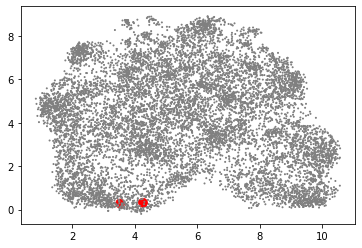

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(embedding_featuer_matrix[:,0], embedding_featuer_matrix[:,1], c=convert_many_hot_to_color(overlap_many_hot),s=size_vector)
plt.show()

In [17]:
sum(overlap_many_hot)

2.0

In [238]:
def show_random_relation(lookup):
    overlap_many_hot,size_vector = random_interaction_two_hot(proteomeHD_simplified_ids,lookup)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(embedding_featuer_matrix[:,0], embedding_featuer_matrix[:,1], c=convert_many_hot_to_color(overlap_many_hot),s=size_vector)
    plt.show()

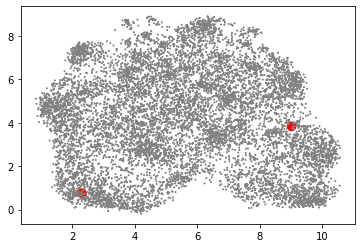

In [282]:
show_random_relation(cocomplex_lookup)

In [281]:
coexpression_lookup = read_json_from(coexpression_lookup_path)
cooccurence_lookup = read_json_from(cooccurence_lookup_path)
experiments_lookup = read_json_from(experiments_lookup_path)
fusion_lookup = read_json_from(fusion_lookup_path)
homology_lookup = read_json_from(homology_lookup_path)
cocomplex_lookup = read_json_from(cocomplex_lookup_path)


In [87]:
np.sum(overlap_many_hot)

3142.0

In [284]:
tSNE_df

,Unnamed: 0,V1,V2,ID
0,1,2.396014,26.475331,A0AV96-2;A0AV96
1,2,47.150187,-18.318122,A0AVT1;A0AVT1-2
2,3,8.381909,-50.684597,A0FGR8-2;A0FGR8;A0FGR8-4
3,4,-42.756864,-8.842151,A0MZ66;A0MZ66-3;A0MZ66-6;A0MZ66-4;A0MZ66-5;A0M...
4,5,10.975579,-55.358026,A1A4S6
...,...,...,...,...
5008,5009,21.402276,-49.187345,Q9Y6X5
5009,5010,-38.503149,31.335396,Q9Y6X8
5010,5011,-50.600414,17.502650,Q9Y6X9;Q9Y6X9-2
5011,5012,9.792972,-10.692080,Q9Y6Y0


In [299]:
jwrite = {}
for idx,row in tSNE_df.iterrows():
    jwrite[row['ID']] = idx
    jwrite[proteomeHD_df.loc[proteomeHD_df['Majority_protein_IDs'] == row['ID']]['Simplified_protein_ID'].values[0]] = idx


In [289]:
#proteomeHD_df.get_loc['A0FGR8-2;A0FGR8;A0FGR8-4']
proteomeHD_df.loc[proteomeHD_df['Majority_protein_IDs'] == 'A0FGR8-2;A0FGR8;A0FGR8-4'].index[0]

4

In [302]:
well

"{'A0AV96-2;A0AV96': 0, 'A0AV96': 0, 'A0AVT1;A0AVT1-2': 1, 'A0AVT1': 1, 'A0FGR8-2;A0FGR8;A0FGR8-4': 2, 'A0FGR8': 2, 'A0MZ66;A0MZ66-3;A0MZ66-6;A0MZ66-4;A0MZ66-5;A0MZ66-8;A0MZ66-2': 3, 'A0MZ66': 3, 'A1A4S6': 4, 'A1L0T0': 5, 'A2RRP1;A2RRP1-2': 6, 'A2RRP1': 6, 'A2RUS2;A2RUS2-2': 7, 'A2RUS2': 7, 'A3KMH1-3;A3KMH1': 8, 'A3KMH1': 8, 'A3KN83-3;A3KN83-2;A3KN83': 9, 'A3KN83': 9, 'A4D1E9;A4D1E9-2': 10, 'A4D1E9': 10, 'A4D1P6;A4D1P6-2;A4D1P6-3': 11, 'A4D1P6': 11, 'A5YKK6;A5YKK6-2;A5YKK6-3;A5YKK6-4': 12, 'A5YKK6': 12, 'A6NC98;A6NC98-4;A6NC98-2': 13, 'A6NC98': 13, 'A6NDG6': 14, 'A6NDU8': 15, 'A6NFQ2;A6NFQ2-3': 16, 'A6NFQ2': 16, 'A6NHL2-2;A6NHL2': 17, 'A6NHL2': 17, 'A6NHQ2': 18, 'A6NHR9;A6NHR9-2': 19, 'A6NHR9': 19, 'A6NIH7': 20, 'A6NJ78': 21, 'A6NKT7': 22, 'A6ZKI3': 23, 'A8CG34;A8CG34-2': 24, 'A8CG34': 24, 'A8MXV4': 25, 'A9UHW6;A9UHW6-2;A9UHW6-3': 26, 'A9UHW6': 26, 'B0I1T2;B0I1T2-4': 27, 'B0I1T2': 27, 'B7ZAQ6-3;B7ZAQ6-2;P0CG08;B7ZAQ6;A6NKF9': 28, 'B7ZAQ6': 28, 'C4AMC7;Q6VEQ5': 29, 'C4AMC7': 29, 'C9JLW8